# 2 Automatic Modulation Classification: Deep Learning Baseline

In this notebook we will go over some PyTorch basics and build a neural network to classify the same data we had for the ML baseline.

## Dependencies

NumPy and Matplotlib are still our everlasting friends, additionally we import PyTorch and some useful modules like nn for neural network layers and optim for optimizers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from ml_helpers import *
from comms_helpers import *

## Data

The training data consists of the 5 modulation classes, each consisting of 128 samples per frame. The difference between the classical ML approach with the decision trees and a DL approach with neural networks is that we do not calculate or engineer features anymore - our raw IQ samples are gonna go straight into the Deep Neural Network (DNN) and through layers of abstraction our model will learn relevant features on its own.

In terms of data preparation we will concatenate frames of raw samples instead of vectors. Additionally now that we are working with PyTorch, we want our data to be converted to torch tensors rather than numpy arrays (this is pretty straightforward and done in the function below).

Since our first layers in the model are going to be convolutional layers (nn.conv2d), the required input tensor shape is (N,C,H,W), where N is the number of frames (or batch size), C is the number of channels (if we were dealing with images this would be RGB), H is the height of our data and W is the width. Complex neural networks aren't quite there yet in mainstream deep learning libraries such as PyTorch, so what people in the wireless communications domain often do is separate the I/Q samples into 2 different channels - in our case we will treat the I/Q channel dimension as the height and the samples as the width.

More concretely, 32x128 (32 frames of 128 complex samples) becomes -> 32x1x2x128 (32 tensors with 2 channels for I/Q, and 128 samples per channel).

In [2]:
def gen_tensor_data(mod_scheme, num_frames=32, samples_per_frame=128, sps=5, snr=30):
            
    symbols_required = int(np.ceil(samples_per_frame/sps))*num_frames
        
    # Mod scheme has to be one of: 'BPSK', 'QPSK', '16-QAM'
    if mod_scheme == 'BPSK':
        symbols = pulse_shape(generate_bpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == 'QPSK':
        symbols = pulse_shape(generate_qpsk(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '8-PSK':
        symbols = pulse_shape(generate_psk8(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '16-QAM':
        symbols = pulse_shape(generate_qam(symbols_required), sps=sps)[:num_frames*samples_per_frame]
    elif mod_scheme == '4-ASK':
        symbols = pulse_shape(generate_ask4(symbols_required), sps=sps)[:num_frames*samples_per_frame]

    # Add noise and split into frames
    frames = awgn(symbols.reshape(num_frames,-1), snr)

    # Normalize to unit energy per frame
    for i, frame in enumerate(frames):
        power = np.mean((np.abs(frame)))
        frames[i] = frame / power

    # Split into I/Q, add extra channel to make a 4-D tensor
    return torch.FloatTensor(np.stack((frames.real, frames.imag),axis=1))

def gen_data_from_list(mod_scheme, snr_range, num_frames=32, samples_per_frame=128):
    
    # total dataset size
    frames = torch.zeros((num_frames*len(snr_range), 2, samples_per_frame), dtype=torch.float)
    
    # snrs dataset for multitask
    snrs = torch.zeros(num_frames*len(snr_range), dtype=torch.float)
    
    for i, snr in enumerate(snr_range):
        frames[i*num_frames:(i+1)*num_frames] = gen_tensor_data(mod_scheme, num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
        snrs[i*num_frames:(i+1)*num_frames] = snr
    
    return frames, snrs

In [3]:
# Function returns a torch dataloader with specified batch_size and num_frames
# number of examples per snr level
def gen_loader(num_frames=32, samples_per_frame=1024, snr=[30], batch_size=32):
    
    # Generate the individual waveforms for each modulation scheme
    bpsk_data, bpsk_snrs = gen_data_from_list('BPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qpsk_data, qpsk_snrs = gen_data_from_list('QPSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    psk_data, psk_snrs = gen_data_from_list('8-PSK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    qam_data, qam_snrs = gen_data_from_list('16-QAM', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    ask_data, ask_snrs = gen_data_from_list('4-ASK', snr, num_frames=num_frames, samples_per_frame=samples_per_frame)
    
    # Concat them into a single training data tensor
    train_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))
    
    # Create class labels
    bpsk_labels = torch.zeros(bpsk_data.shape[0])
    qpsk_labels = torch.ones(qpsk_data.shape[0])
    psk_labels = torch.ones(psk_data.shape[0])*2
    qam_labels = torch.ones(qam_data.shape[0])*3
    ask_labels = torch.ones(ask_data.shape[0])*4

    # Concat class labels
    # We will be using cross entropy loss, which expects a long tensor as the label hence the .long() here
    train_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels)).long()
    
    # SNR labels
    train_labels_snr = 1/10**(torch.cat((bpsk_snrs, qpsk_snrs, psk_snrs, qam_snrs, ask_snrs))/10) # linear noise as labels
    
    # if gpu
    train_data = train_data.cuda()
    train_labels = train_labels.cuda()
    train_labels_snr = train_labels_snr.cuda()
    
    # Create a Torch dataset
    train_dataset = torch.utils.data.TensorDataset(train_data, train_labels, train_labels_snr)
    
    return torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

We can generate a test dataloader and see how it behaves. We generate 128 frames per SNR per modulation scheme, so we expect to have 128x3x5=1920 examples.

In [4]:
data_loader = gen_loader(num_frames=128, snr=[10,15,20], batch_size=32)
print(len(data_loader))

60


However length is 60... What's wrong? Well torch dataloaders are iterables, and we gave ours a batch_size of 32, meaning each iteration we expect 32 frames to pop out. So if we multiply our result by the batch size

In [5]:
len(data_loader)*32

1920

Presto! Exactly what we expected. Now onto the model building.

## Model

Each PyTorch model is defined as its own class which inherits all of its functionality from the base nn.Module. Typically you only need to flesh out its 2 functions:
* **\_\_init__** - where we will define all the layers we'll want to use in the model - you can even pass arguments to the constructor and make these conditional!
* **forward** - the forward pass function, that actually applies all these layers to our input. If you are familiar with backpropagation, yes this is that forward pass, however the PyTorch autograd capabilities take care of all the training details for us, so we don't really have to worrry about any gradients or backward passes.

We will be using a relatively small network with 3 convolutional layers and 2 fully connected layers with the final output being 5 neurons wide for our 5 classes.

## Add MTL

In [6]:
class amc_model_mtl(nn.Module):
    def __init__(self):
        super(amc_model_mtl, self).__init__()
            
        # 3 conv layers with a 9 sample wide kernel and padding so that the
        # size of the output remains consistent with the input for each layer
        self.convolutions = nn.Sequential(
                    nn.Conv1d(2, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU(),
                    nn.Conv1d(64, 64, 3, padding=1),
                    nn.MaxPool1d(2),
                    nn.ReLU()
                    )
        
        # Noise estimator network
        self.noise_estimator = nn.Sequential(
                                    nn.Linear(512,512),
                                    nn.ReLU(),
                                    nn.Linear(512,128),
                                    nn.ReLU(),
                                    nn.Linear(128,64),
                                    nn.ReLU(),
                                    nn.Linear(64,1))
        
        # 128 samples x 16 output filters x 2 channels (I/Q) = 4096
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, x):
        
        # Extract features with convolutional layers
        x = self.convolutions(x)
        
        # Flatten so it's compatible with fully connected layers for classification
        x_shared = torch.flatten(x,1)
#         print(x.shape)
        
#         First fully connected layer
        y = F.selu(self.fc1(x_shared))
        
        # Final layer responsible for classifying the 5 modulation schemes
        y = F.selu(self.fc2(y))
        
        y = self.fc3(y)
        
        n = self.noise_estimator(x_shared).squeeze()
        
        return y, n

In [7]:
model_mtl = amc_model_mtl()
model_mtl

amc_model_mtl(
  (convolutions): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU()
    (15): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (16): MaxPool1d(kernel_size=2, s

In [8]:
def train_model_mtl(model, optimizer, train_loader, val_loader, num_epochs=5, verbose=True, loss_ratios=(0.5, 0.5)):

    losses, val_losses = [], []
    losses_mod, val_losses_mod = [], []
    losses_snr, val_losses_snr = [], []
    
    loss_class = nn.CrossEntropyLoss()#nn.MSELoss()
    loss_snr = nn.MSELoss()

    # Main training loop
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0

        best_loss = np.inf

        # Loop over entire training loader
        for x_train, y_train, z_train in train_loader:

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat, n_estim = model(x_train)
            loss_1 = loss_class(y_hat, y_train)
            loss_2 = loss_snr(n_estim, z_train)
            
            loss = loss_1*loss_ratios[0] + loss_2*loss_ratios[1]
            
            loss.backward()
            optimizer.step()
            
            losses_mod.append(loss_1.item())
            losses_snr.append(loss_2.item())

            # Add to running loss, average later
            running_loss = running_loss + loss.item()

        # Append average loss for this epoch to losses list
        losses.append(running_loss/len(train_loader))

        # Evaluate validation loss

        with torch.no_grad():

            running_val_loss = 0

            for x_val, y_val, z_val in val_loader:

                # evaluate validation loss
                val_outputs, val_snr = model(x_val)
                val_loss1 = loss_class(val_outputs, y_val)
                
                val_loss2 = loss_snr(val_snr, z_val)

                running_val_loss = running_val_loss + val_loss1.item()
                
                val_losses_mod.append(val_loss1.item())
                val_losses_snr.append(val_loss2.item())

            val_losses.append(running_val_loss/len(val_loader))

        if val_losses[-1] < best_loss:
            saved_model = model.state_dict()
            best_loss = val_losses[-1]
            
        if verbose:
            print('Epoch {}: {}'.format(epoch,losses[-1]))

    # Load best model
    model.load_state_dict(saved_model)
    
    return model, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr

In [15]:
num_epochs = 15

train_snr = np.arange(0,21,2)

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

model_mtl = amc_model_mtl()
model_mtl.cuda()

optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.001, weight_decay=0.0001)

model_mtl, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr = \
train_model_mtl(model_mtl, optimizer, train_loader, val_loader, num_epochs=num_epochs, verbose=True, loss_ratios=(1,0.1))

Epoch 0: 0.49849858552810145
Epoch 1: 0.14236786863290365
Epoch 2: 0.068927002905614
Epoch 3: 0.05429347422429022
Epoch 4: 0.04323050638803662
Epoch 5: 0.03537645710570029
Epoch 6: 0.029614927920391148
Epoch 7: 0.031334342290673785
Epoch 8: 0.027890330996425208
Epoch 9: 0.023303024927273243
Epoch 10: 0.02320669076924043
Epoch 11: 0.020926599268386782
Epoch 12: 0.01939980713257021
Epoch 13: 0.015756977002258116
Epoch 14: 0.017992677301431698


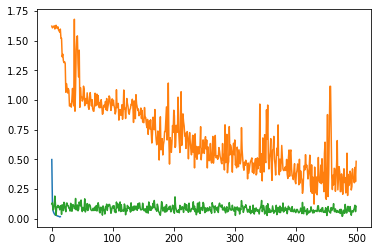

In [16]:
plt.plot(losses[:500])
plt.plot(losses_mod[:500])
plt.plot(losses_snr[:500])

In [9]:
def test_model_mtl(model, snr_range, num_frames=128, samples_per_frame=1024):
    accs = []
    snr_errs = []

    model.eval().cpu()

    with torch.no_grad():
        for snr in snr_range:

            bpsk_data = gen_tensor_data('BPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qpsk_data = gen_tensor_data('QPSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            psk_data = gen_tensor_data('8-PSK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            qam_data = gen_tensor_data('16-QAM', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)
            ask_data = gen_tensor_data('4-ASK', num_frames=num_frames, samples_per_frame=samples_per_frame, snr=snr)

            test_data = torch.cat((bpsk_data, qpsk_data, psk_data, qam_data, ask_data))

            bpsk_labels = torch.zeros(bpsk_data.shape[0])
            qpsk_labels = torch.ones(qpsk_data.shape[0])
            psk_labels = torch.ones(qam_data.shape[0])*2
            qam_labels = torch.ones(qam_data.shape[0])*3
            ask_labels = torch.ones(ask_data.shape[0])*4

            test_labels = torch.cat((bpsk_labels, qpsk_labels, psk_labels, qam_labels, ask_labels))

            y_hat, snr_hat = model(test_data)
            
            results = torch.argmax(y_hat,axis=1)
            
            snr_errs.append(F.mse_loss(snr_hat, 1/10**(torch.ones_like(snr_hat)*snr/10)))
            
            accs.append(torch.sum(results == test_labels).float() / test_data.shape[0])
            
    return accs, snr_errs

In [10]:
snr_range = np.arange(-10,25)
accs_mtl = test_model_mtl(model_mtl, snr_range, num_frames=512)

KeyboardInterrupt: 

In [56]:
baseline_data = np.load('baselines/dl_baseline.npz')
baseline = baseline_data['baseline']

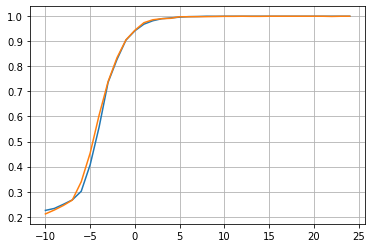

In [20]:
plt.plot(snr_range, baseline)
plt.plot(snr_range, accs_mtl[0])
plt.grid()

Train models

In [29]:
model_config = {"weights": model_mtl.state_dict(),
                "losses": losses,
                "val_losses": val_losses,
                "losses_mod": losses_mod,
                "losses_snr": losses_snr,
                "val_losses_mod": val_losses_mod,
                "val_losses_snr": val_losses_snr}

In [33]:
torch.save(test_models, 'models/test.pt')
# torch.load('models/test.pt')

In [38]:
round(0.11,1)

0.11

In [48]:
num_epochs = 20
train_snr = np.arange(-4,12,2)
num_iter = 5

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)
# train_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32)
# val_loader = gen_loader(num_frames=32, snr=train_snr, batch_size=32)

for i in range(1,10):
    models = []
    
    amc_weight = round(i*0.1, 1)
    snr_weight = round(1 - amc_weight, 1)
    
    loss_ratios = (amc_weight, snr_weight)
    print(loss_ratios)
    accs = 0
    for j in range(num_iter):
        print(f"iter {j}")
        model_mtl = amc_model_mtl()
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.001, weight_decay=0.0001)

        model_mtl, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr = \
        train_model_mtl(model_mtl, optimizer, train_loader, val_loader, num_epochs=num_epochs, verbose=False, loss_ratios=loss_ratios)
        
        model_config = {"weights": model_mtl.state_dict(),
                        "losses": losses,
                        "val_losses": val_losses,
                        "losses_mod": losses_mod,
                        "losses_snr": losses_snr,
                        "val_losses_mod": val_losses_mod,
                        "val_losses_snr": val_losses_snr}
        
        models.append(model_config)
    torch.save(models, f'models/amc_{amc_weight}_{snr_weight}.pt')

(0.1, 0.9)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.2, 0.8)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.3, 0.7)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.4, 0.6)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.5, 0.5)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.6, 0.4)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.7, 0.3)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.8, 0.2)
iter 0
iter 1
iter 2
iter 3
iter 4
(0.9, 0.1)
iter 0
iter 1
iter 2
iter 3
iter 4


Test models

In [50]:
import os

In [51]:
snr_range = np.arange(-15,15)

for models in sorted(os.listdir('models')):
    print(models)
    results = []
    for model in torch.load(f'models/{models}'):
        model_mtl = amc_model_mtl()
        model_mtl.load_state_dict(model['weights'])
        accs_mod, accs_snr = np.array(test_model_mtl(model_mtl, snr_range, num_frames=32))
#             accs_mod.append(accs_mod_hat)
#             accs_snr.append(accs_snr_hat)
        
        result = {"accs_mod": accs_mod,
                   "accs_snr": accs_snr,
                   "snr_range": snr_range,
                   "model": model}
        results.append(result)
    torch.save(results, f'results/{models}')

amc_0.1_0.9.pt
amc_0.2_0.8.pt
amc_0.3_0.7.pt
amc_0.4_0.6.pt
amc_0.5_0.5.pt
amc_0.6_0.4.pt
amc_0.7_0.3.pt
amc_0.8_0.2.pt
amc_0.9_0.1.pt


Analyze results

amc_0.1_0.9.pt
amc_0.2_0.8.pt
amc_0.3_0.7.pt
amc_0.4_0.6.pt
amc_0.5_0.5.pt
amc_0.6_0.4.pt
amc_0.7_0.3.pt
amc_0.8_0.2.pt
amc_0.9_0.1.pt


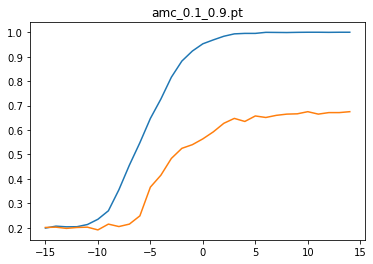

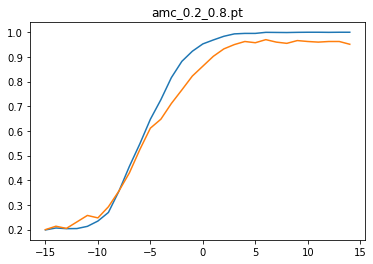

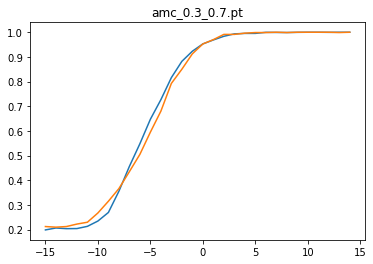

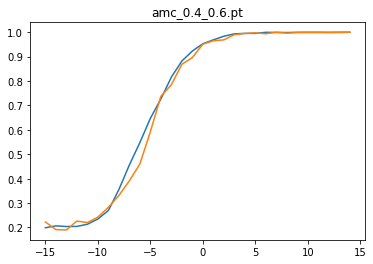

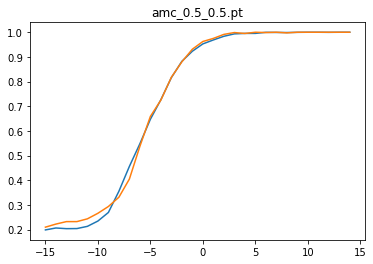

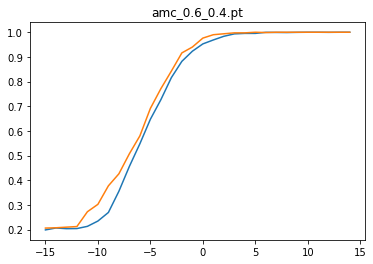

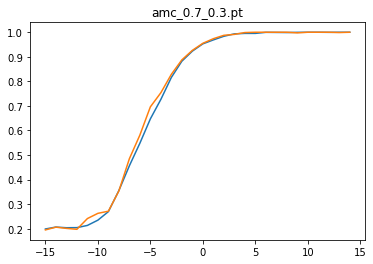

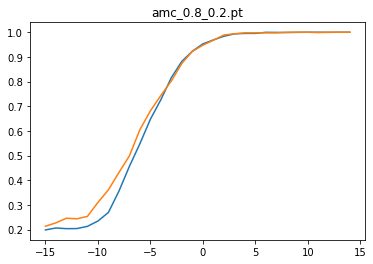

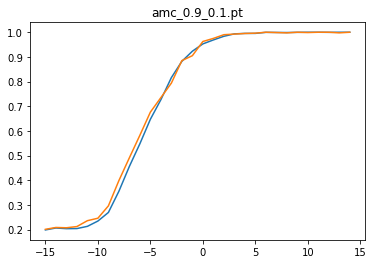

In [57]:
for results in sorted(os.listdir('results')):
    print(results)
    plt.figure()
    plt.plot(snr_range, baseline)
    accs = 0
    for model in torch.load(f'results/{results}'):
        accs += np.array(model['accs_mod']).T
    plt.plot(snr_range, accs/5)
    plt.title(results)

amc_0.1_0.9.pt
amc_0.2_0.8.pt
amc_0.3_0.7.pt
amc_0.4_0.6.pt
amc_0.5_0.5.pt
amc_0.6_0.4.pt
amc_0.7_0.3.pt
amc_0.8_0.2.pt
amc_0.9_0.1.pt


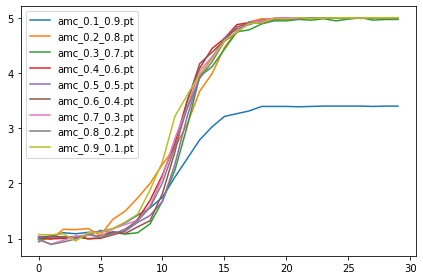

In [37]:
legend = []
accs_list = []
for results in sorted(os.listdir('results')):
    print(results)
#     plt.figure()
#     plt.plot(snr_range, baseline)
    accs = 0
    for model in torch.load(f'results/{results}'):
        accs += np.array(model['accs_mod']).T
#     plt.plot(snr_range[:15], accs[:15]/5)
    accs_list.append(accs)
    legend.append(results)
plt.plot(np.array(accs_list).T)
plt.legend(legend)
plt.tight_layout()

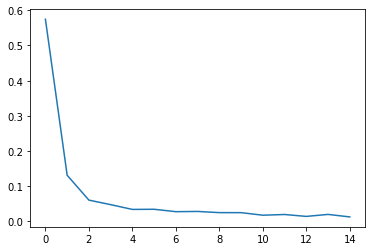

In [46]:
plt.plot(config['losses'])

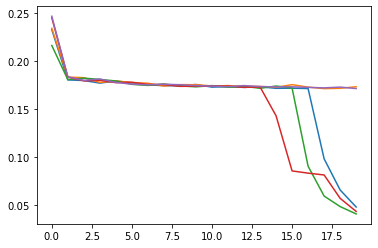

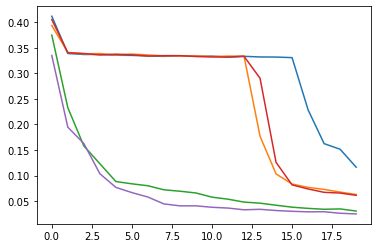

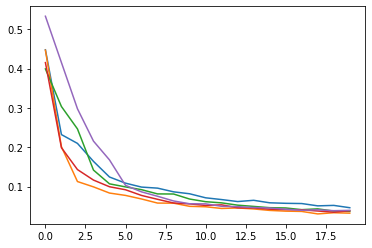

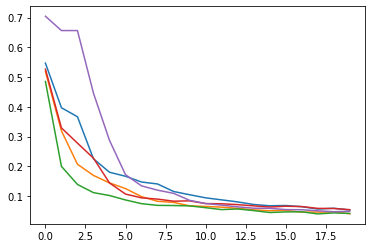

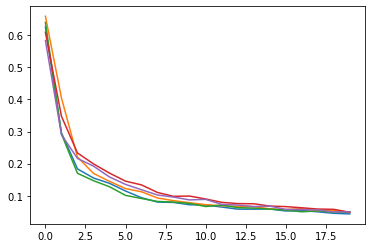

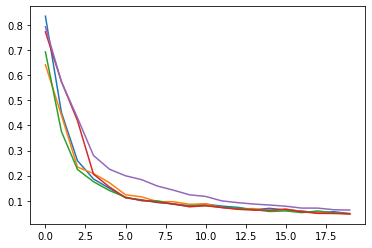

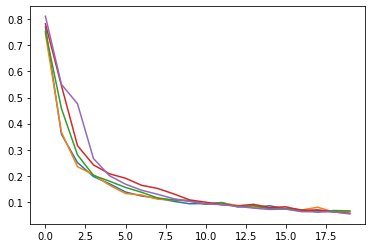

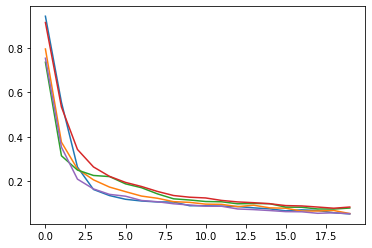

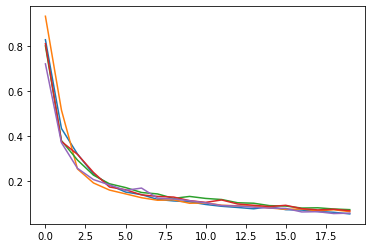

In [58]:
for model_config in sorted(os.listdir('models')):
    configs = torch.load(f'models/{model_config}')
    plt.figure()
    for config in configs:
        plt.plot(config['losses'])
#     plt.plot(model_config['val_losses'],'--')

In [42]:
model_config

'amc_0.1_0.9.pt'

In [ ]:
## TODO:
## Shift snr_range to (-15,20)
## Run baseline multiple times

In [ ]:
snr_range = np.arange(-10,25)

all_accs, all_accs_snr = [], []

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

plt.plot(snr_range, baseline)

for i in range(1,10):
    amc_weight = i*0.1
    snr_weight = 1 - amc_weight
    
    loss_ratios = (amc_weight, snr_weight)
    print(loss_ratios)
    accs = 0
    for j in range(num_iter):
        print(f"iter {j}")
        model_mtl = amc_model_mtl()
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.001, weight_decay=0.0001)

        model_mtl, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr = \
        train_model_mtl(model_mtl, optimizer, train_loader, val_loader, num_epochs=num_epochs, verbose=False, loss_ratios=loss_ratios)

        accs += np.array(test_model_mtl(model_mtl, snr_range, num_frames=512)[0])
#     plt.plot(snr_range, accs_mtl[0])
    all_accs.append(accs/num_iter)

(0.1, 0.9)
iter 0
iter 1
iter 2
(0.2, 0.8)
iter 0
iter 1
iter 2
(0.30000000000000004, 0.7)
iter 0
iter 1
iter 2
(0.4, 0.6)
iter 0
iter 1
iter 2
(0.5, 0.5)
iter 0
iter 1
iter 2
(0.6000000000000001, 0.3999999999999999)
iter 0
iter 1
iter 2
(0.7000000000000001, 0.29999999999999993)
iter 0
iter 1
iter 2
(0.8, 0.19999999999999996)
iter 0
iter 1
iter 2
(0.9, 0.09999999999999998)
iter 0
iter 1
iter 2


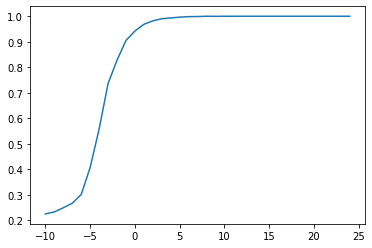

In [53]:
num_epochs = 15
train_snr = np.arange(0,21,2)
snr_range = np.arange(-10,25)
num_iter = 3

all_accs, all_accs_snr = [], []

train_loader = gen_loader(num_frames=512, snr=train_snr, batch_size=32)
val_loader = gen_loader(num_frames=128, snr=train_snr, batch_size=32)

plt.plot(snr_range, baseline)

for i in range(1,10):
    amc_weight = i*0.1
    snr_weight = 1 - amc_weight
    
    loss_ratios = (amc_weight, snr_weight)
    print(loss_ratios)
    accs = 0
    for j in range(num_iter):
        print(f"iter {j}")
        model_mtl = amc_model_mtl()
        model_mtl.cuda()

        optimizer = torch.optim.Adam(model_mtl.parameters(), lr=0.001, weight_decay=0.0001)

        model_mtl, losses, val_losses, losses_mod, losses_snr, val_losses_mod, val_losses_snr = \
        train_model_mtl(model_mtl, optimizer, train_loader, val_loader, num_epochs=num_epochs, verbose=False, loss_ratios=loss_ratios)

        accs += np.array(test_model_mtl(model_mtl, snr_range, num_frames=512)[0])
#     plt.plot(snr_range, accs_mtl[0])
    all_accs.append(accs/num_iter)
#     all_accs_snr.append(accs_mtl[1])

In [56]:
weights_legend = ['baseline']

for i in range(1,10):
    amc_weight = i*0.1
    snr_weight = 1 - amc_weight
    
    loss_ratios = (round(amc_weight, ndigits=1), round(snr_weight, ndigits=1))
    weights_legend.append(loss_ratios)

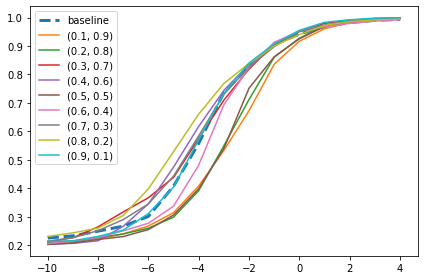

In [57]:
plt.plot(snr_range[:15], baseline[:15], '--', linewidth=3)
for acc in all_accs:
    plt.plot(snr_range[:15], acc[:15])
plt.legend(weights_legend)
plt.tight_layout()

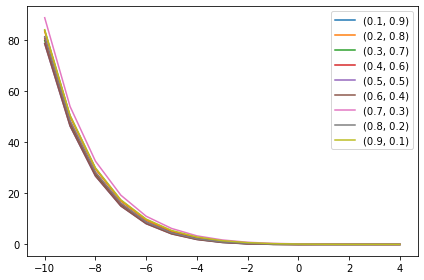

In [47]:
# plt.plot(snr_range[:15], baseline[:15], '--', linewidth=3)
for acc in all_accs_snr:
    plt.plot(snr_range[:15], acc[:15])
plt.legend(weights_legend[1:])
plt.tight_layout()

In [40]:
weights_legend

['baseline',
 (0.1, 0.9),
 (0.2, 0.8),
 (0.3, 0.7),
 (0.4, 0.6),
 (0.5, 0.5),
 (0.6, 0.4),
 (0.7, 0.3),
 (0.8, 0.2),
 (0.9, 0.1)]